In [ ]:
!pip install -q numpy pandas sklearn xgboost
!pip install -q vectice
!pip install -q fsspec
!pip install -q gcsfs 
!pip install -q mlflow

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns #visualization of the variables
import os

from scipy.stats import chi2_contingency, ttest_ind

from xgboost import XGBClassifier
from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score

from vectice import Vectice
from vectice.models.job_type import JobType
from vectice.entity.model import ModelType
from vectice.entity.model_version import ModelVersionStatus

# Stroke Prediction Research:
The main question is that we want to understand how the predictor variables can help estimate the probability of suffering a stroke.

## Is there other than age relationship?
Does having a heart disease or high BMI and glucose level related to have a higher change of suffering a stroke?
Plans:
We should visualize a distribution of the target variable, which is the stroke, then a distribution of variables in respect to the target variable.

Split the model into categorial features and objects. - Done. Do Hot encoding?
Call the distributions on an object based way e.g. fig, ax.
Continue building on the models. Next XGBoost.
Predict, predict, predict.
Draw final conclusions.
Add an index to notebook.
Add more distribution visualizations.
Models:
Logistic regression, random forest and xgboost.

## Exploratory Data Analysis (EDA)
It's nothing but a data exploration technique to understand the various aspects of the data. The idea is to check for relationship between variables and to check their distributions.

It follows a systematic set of steps to explore the data in the most efficient way possible

## Steps:

- Understand the Data

- Clean up the Data

- Analysis of relationships between variables

## Vectice Credentials 

To connect to the Vectice App through the SDK you'll need the Project Token, Vectice API Endpoint and the Vectice API Token. You'll find all of this in the Vectice App. The Workspace allows you to create the Vectice API Token, in Projects you'll be able to get the Project Token, as seen below. The Vectice API Endpoint is 'https://beta.vectice.com'. You're provided with the GCS Service Account JSON, which will allow you to connect to the GCS Bucket in the Vectice App and get the needed data for the example. 

## Credentials Setup:
The Vectice API Endpoint and Token are needed to connect to the Vectice UI. Furthermore, a Google Cloud Storage credential JSON is needed to connect to the Google Cloud Storage to retrieve and upload the datasets. A project token links the runs to the relevant project and it's needed to create runs.

In [ ]:
# Vectice Project Token
PROJECT_TOKEN = ""
# The GCS permissions scope
SCOPES = ['https://www.googleapis.com/auth/bigquery.readonly']  

os.environ["VECTICE_API_ENDPOINT"] = "beta.vectice.com"  
os.environ["VECTICE_API_TOKEN"] = "" 
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = ""

In [ ]:
# Upload your GCS Storage json for access to GCS
from google.colab import files
uploaded = files.upload()

In [ ]:
from google.cloud import bigquery

# Big Query Project ID
project_id = ""

In [ ]:
# Vectice App Connection
vectice = Vectice(PROJECT_TOKEN)
# Creating a run and assigning it's job type
run = vectice.create_run("StrokeData BigQuery Ingest", JobType.PREPARATION)
# Starting a run
vectice.start_run(run)

In [ ]:
# Client connection to Big Query
client = bigquery.Client(project=project_id)

df = client.query('''
  SELECT * FROM `nodal-unity-277700.healthcareData.StrokeData`''')

data = df.to_dataframe()
data.head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,64128,Male,10.0,0,0,False,children,Urban,63.08,20.5,smokes,0
1,4833,Female,12.0,0,0,False,children,Rural,207.45,25.4,smokes,0
2,42821,Female,13.0,0,0,False,Private,Rural,60.69,24,smokes,0
3,37395,Female,16.0,0,0,False,Private,Urban,63.63,20,smokes,0
4,63312,Male,16.0,0,0,False,Private,Urban,80.55,23.5,smokes,0


In [ ]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,64128,Male,10.0,0,0,False,children,Urban,63.08,20.5,smokes,0
1,4833,Female,12.0,0,0,False,children,Rural,207.45,25.4,smokes,0
2,42821,Female,13.0,0,0,False,Private,Rural,60.69,24,smokes,0
3,37395,Female,16.0,0,0,False,Private,Urban,63.63,20,smokes,0
4,63312,Male,16.0,0,0,False,Private,Urban,80.55,23.5,smokes,0


In [ ]:
# Creating a dataset as an output 
dataset = [vectice.create_dataset_version().with_parent_name("Stroke Data").with_property("Query", df.query)]

In [ ]:
# Ending the run and assigning the output to the run
vectice.end_run(outputs=dataset)

2119

In [ ]:
data['bmi'] = pd.to_numeric(data['bmi'], errors='coerce')

In [ ]:
#Categorical info
cat_feat = [i for i in data.columns if data[i].dtype == 'object' or data[i].dtype == 'bool']
cat_feat

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

In [ ]:
#remove categorial data from our set to create the model. Can be added encoded later in the process.
num_feat = data.drop(cat_feat, axis = 1)

In [ ]:
data.shape

(5110, 12)

In [ ]:
data.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [ ]:
# The ID column is useless for the analysis, so we drop it
num_feat = num_feat.drop('id', axis = 1)

In [ ]:
# num_feat.groupby(num_feat['bmi'].isnull()).mean()
num_feat.isna().sum()

age                    0
hypertension           0
heart_disease          0
avg_glucose_level      0
bmi                  201
stroke                 0
dtype: int64

In [ ]:
# 97.6 BMI? That is odd, but it is what the "max" value shows us. Let's find out how many occurrences there are
num_feat[num_feat['bmi']==97.6]

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
1331,17.0,1,0,61.67,97.6,0


In [ ]:
data[data['bmi']==97.6]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1331,56420,Male,17.0,1,0,False,Private,Rural,61.67,97.6,Unknown,0


In [ ]:
num_feat = num_feat[num_feat['bmi']!=97.6]

In [ ]:
#Checking again
num_feat[num_feat['bmi']>40] #sort_values('bmi')

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
39,22.0,0,0,73.50,41.3,0
41,22.0,0,0,102.00,40.4,0
44,23.0,1,0,70.03,78.0,0
67,24.0,0,0,83.10,42.5,0
79,25.0,0,0,108.82,41.3,0
...,...,...,...,...,...,...
4950,66.0,1,0,205.01,52.7,0
4954,66.0,0,1,196.58,41.9,0
4961,70.0,1,0,242.52,45.5,1
4971,70.0,0,1,93.02,40.2,0


In [ ]:
num_feat.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5109.000000,5109.000000,5109.000000,5109.000000,4908.000000,5109.000000
mean,43.231748,0.097279,0.054022,106.156383,28.879238,0.048738
std,22.611882,0.296367,0.226084,45.283716,7.793377,0.215340
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.260000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.890000,28.050000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,92.000000,1.000000


In [ ]:
num_feat.groupby('stroke').mean()

,age,hypertension,heart_disease,avg_glucose_level,bmi
stroke,,,,,
0,41.976683,0.088683,0.047119,104.804387,28.808427
1,67.728193,0.265060,0.188755,132.544739,30.471292


In [ ]:
num_feat.groupby(num_feat.bmi > 40)[['stroke', 'hypertension', 'heart_disease']].sum()

,stroke,hypertension,heart_disease
bmi,,,
False,231,429,264
True,18,68,12


In [ ]:
bmi_over_40 = num_feat[num_feat['bmi'] > 40 ]

In [ ]:
bmi_over_40[num_feat['stroke'] == 1 ].sort_values(by='age')

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
1939,43.0,0,0,143.43,45.9,1
3697,45.0,0,0,224.10,56.6,1
4769,47.0,0,0,86.94,41.1,1
4796,51.0,1,0,112.16,42.5,1
3131,52.0,1,0,233.29,48.9,1
3825,53.0,0,0,64.17,41.5,1
347,54.0,0,0,191.82,40.4,1
4492,56.0,0,0,185.17,40.4,1
672,57.0,1,0,212.08,44.2,1
2072,59.0,0,0,96.16,44.1,1


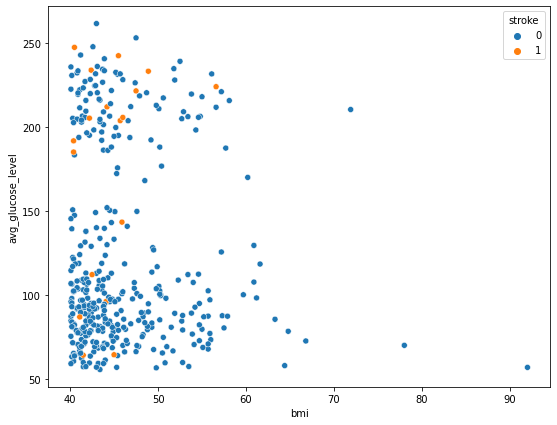

In [ ]:
plt.figure(figsize = (9,7))
sns.scatterplot(x = 'bmi', y = 'avg_glucose_level', hue = 'stroke', data =bmi_over_40)
plt.show()

Adult Body Mass Index (BMI)¶
BMI does not measure body fat directly, but research has shown that BMI is moderately correlated with more direct measures of body fat obtained from skinfold thickness measurements, bioelectrical impedance, underwater weighing, dual energy x-ray absorptiometry (DXA) and other methods 1,2,3. Furthermore, BMI appears to be strongly correlated with various adverse health outcomes consistent with these more direct measures of body fatness

In [ ]:
#check for unique values
data.nunique()

id                   5110
gender                  3
age                   104
hypertension            2
heart_disease           2
ever_married            2
work_type               5
Residence_type          2
avg_glucose_level    3979
bmi                   418
smoking_status          4
stroke                  2
dtype: int64

It seems the majorities of values are binaries, which mean that they are categorical values e.g. "yes" or "no" except for gender which is says it has 3 types. We need to check if that is not because a typo or blank entries.

The categorial variables with more different values are the following in ascending order:

smoking_status 4
work_type 5

In [ ]:
data.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [ ]:
data = data[data['gender']!='Other']

In [ ]:
data.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     884
smokes              789
Name: smoking_status, dtype: int64

In [ ]:
data[data['smoking_status'] == 'Unknown']

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
789,5010,Female,2.00,0,0,False,children,Rural,92.48,18.0,Unknown,0
790,15274,Female,2.00,0,0,False,children,Rural,79.89,31.6,Unknown,0
791,8320,Male,2.00,0,0,False,children,Rural,73.62,20.8,Unknown,0
792,14387,Male,2.00,0,0,False,children,Urban,93.88,17.4,Unknown,0
793,65218,Male,2.00,0,0,False,children,Rural,109.10,20.0,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2328,69435,Female,0.56,0,0,False,children,Urban,80.92,18.3,Unknown,0
2329,47848,Male,1.56,0,0,False,children,Rural,93.74,20.1,Unknown,0
2330,16061,Female,1.56,0,0,False,children,Urban,113.40,19.5,Unknown,0
2331,41042,Female,1.56,0,0,False,children,Urban,71.81,22.6,Unknown,0


In [ ]:
#smokers and goverment jobs
smokers = data[data['smoking_status']=='smokes']

smokers.work_type.value_counts(normalize=True)

Private          0.688213
Self-employed    0.157161
Govt_job         0.152091
children         0.002535
Name: work_type, dtype: float64

In [ ]:
smokers['age'].groupby(smokers['age']).count()

age
10.0    1
12.0    1
13.0    1
16.0    2
17.0    4
       ..
78.0    7
79.0    9
80.0    7
81.0    5
82.0    6
Name: age, Length: 70, dtype: int64

In [ ]:
# Creating a dataset as an input for the run
input = [vectice.create_dataset_version().with_parent_name("Stroke Data")]
# Creating a run and assigning it's job type
run = vectice.create_run('Stroke Data Cleaning', JobType.PREPARATION)
# Starting the run and assigning the inputs from above
vectice.start_run(run, inputs=input)

In [ ]:
#handling missing values
data['bmi'] = data['bmi'].fillna(round (data['bmi'].median(), 2))
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [ ]:
# Uploading the cleaned data into BigQuery
# TODO(developer): Set table_id to the ID of the table to create.
table_id = "nodal-unity-277700.healthcareData.StrokeDataClean"

# The job_config holds schema information. Column names, data types etc. 
job_config = bigquery.LoadJobConfig(
    schema=[bigquery.SchemaField(col, str(data[col].dtype if data[col].dtype != 'object' else "STRING")) for col in data.columns],
)

load_job = client.load_table_from_dataframe(
    data, table_id, job_config=job_config
)  # Make an API request.

load_job.result()  # Waits for the job to complete.

destination_table = client.get_table(table_id)  # Make an API request.
print("Loaded {} rows.".format(destination_table.num_rows))

Loaded 5110 rows.


In [ ]:
# Creating the new dataset as an output for the run 
output = [vectice.create_dataset_version().with_parent_name("Stroke Data Clean").with_property("Fillna", "Median")]
vectice.end_run(outputs=output)

2065

In [ ]:
correlation = data.drop('id', axis = 1).corr()

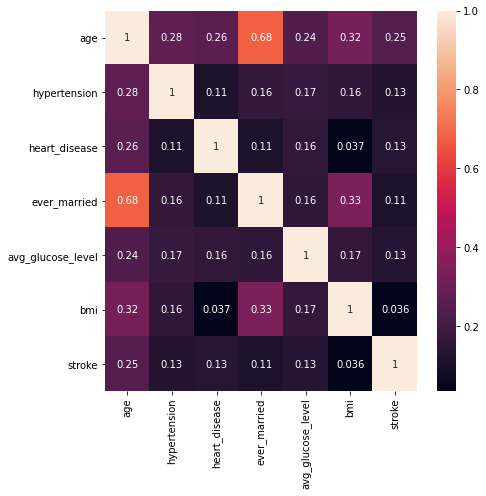

In [ ]:
plt.figure(figsize=(7,7))
sns.heatmap(correlation, xticklabels =correlation.columns, yticklabels = correlation.columns, annot=True)
plt.show()

As we can see it looks that the more related variable to stroke is the age feature. We may consider to use a model to only use the wanted variables to remove id for example.

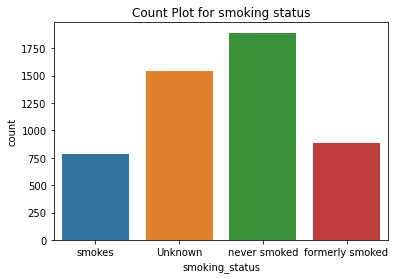

In [ ]:
sns.countplot(x = 'smoking_status', data = data)
plt.title("Count Plot for smoking status")
plt.show()

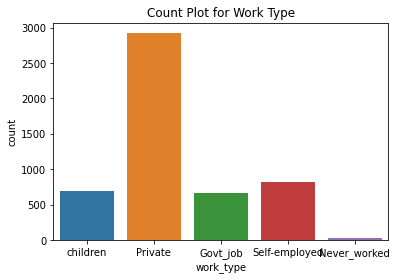

In [ ]:
sns.countplot(x = 'work_type', data = data)
plt.title('Count Plot for Work Type')
plt.show()

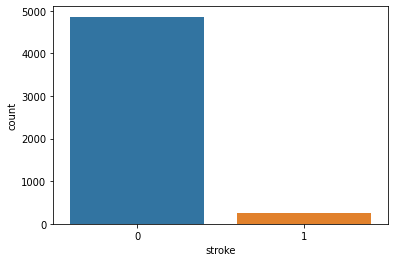

In [ ]:
#Ploting the distribution of Stroke
num_data = num_feat
sns.countplot(x='stroke', data=num_data)
plt.show()

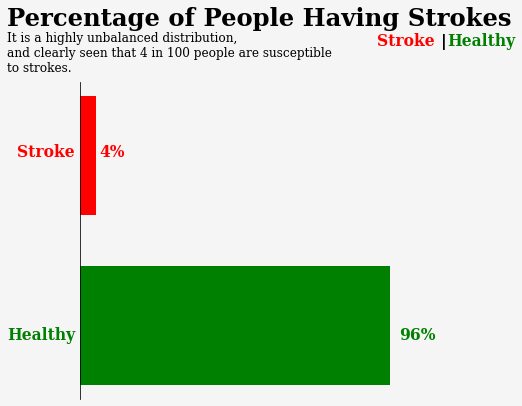

In [ ]:
x = pd.DataFrame(num_data.groupby(['stroke'])['stroke'].count())

# plot
fig, ax = plt.subplots(figsize = (6,6), dpi = 70)
ax.barh([1], x.stroke[1], height = 0.7, color = 'red')
plt.text(-1150,-0.08, 'Healthy',{'fontfamily': 'Serif','weight':'bold','Size': '16','style':'normal', 'color':'green'})
#plt.text(5000,-0.08, '95%',{'font':'Serif','weight':'bold' ,'size':'16','color':'green'})
plt.text(5000,-0.08, f"{(num_data.shape[0]/num_data.shape[0]*100) - (x.shape[0]/(num_data.shape[0])*100)*100:.0f}%" ,{'fontfamily':'Serif','weight':'bold' ,'size':'16','color':'green'})
ax.barh([0], x.stroke[0], height = 0.7, color = 'green')
plt.text(-1000,1, 'Stroke', {'fontfamily': 'Serif','weight':'bold','Size': '16','style':'normal', 'color':'red'})
plt.text(300,1, f"{((x.shape[0]/data.shape[0])*100)*100:.0f}%",{'fontfamily':'Serif', 'weight':'bold','size':'16','color':'red'})

fig.patch.set_facecolor('#f6f5f5')
ax.set_facecolor('#f6f5f5')

plt.text(-1150,1.77, 'Percentage of People Having Strokes' ,{'fontfamily': 'Serif', 'Size': '25','weight':'bold', 'color':'black'})
plt.text(4650,1.65, 'Stroke ', {'fontfamily': 'Serif','weight':'bold','Size': '16','weight':'bold','style':'normal', 'color':'red'})
plt.text(5650,1.65, '|', {'color':'black' , 'size':'16', 'weight': 'bold'})
plt.text(5750,1.65, 'Healthy', {'fontfamily': 'Serif','weight':'bold', 'Size': '16','style':'normal', 'weight':'bold','color':'green'})
plt.text(-1150,1.5, 'It is a highly unbalanced distribution,\nand clearly seen that 4 in 100 people are susceptible \nto strokes.', 
        {'fontfamily':'Serif', 'size':'12.5','color': 'black'})

ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

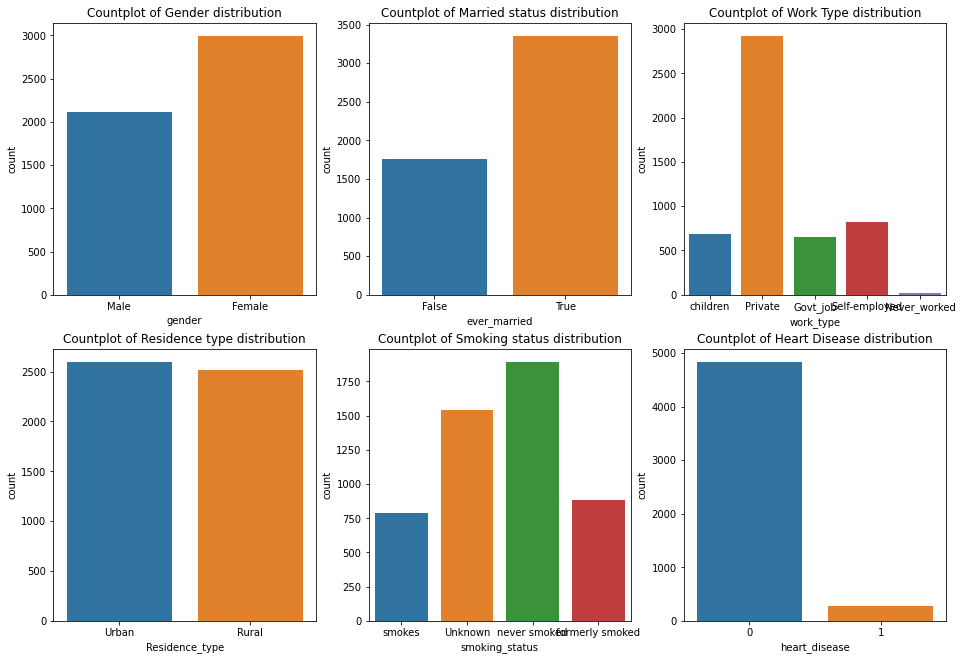

In [ ]:
plt.figure(figsize = (16,11))
plt.subplot(2,3,1)
sns.countplot(x = 'gender', data = data)
plt.title('Countplot of Gender distribution')

plt.subplot(2,3,2)
sns.countplot(x = 'ever_married', data = data)
plt.title('Countplot of Married status distribution')

plt.subplot(2,3,3)
sns.countplot(x='work_type', data = data)
plt.title('Countplot of Work Type distribution')

plt.subplot(2,3,4)
sns.countplot(x = 'Residence_type', data = data)
plt.title('Countplot of Residence type distribution')

plt.subplot(2,3,5)
sns.countplot(x = 'smoking_status',data = data)
plt.title('Countplot of Smoking status distribution')

plt.subplot(2,3,6)
sns.countplot(x = 'heart_disease',data = data)
plt.title('Countplot of Heart Disease distribution')
plt.show()

In [ ]:
num_data = num_feat
#handling missing values
num_data['bmi'] = num_data['bmi'].fillna(round (num_data['bmi'].median(), 2))

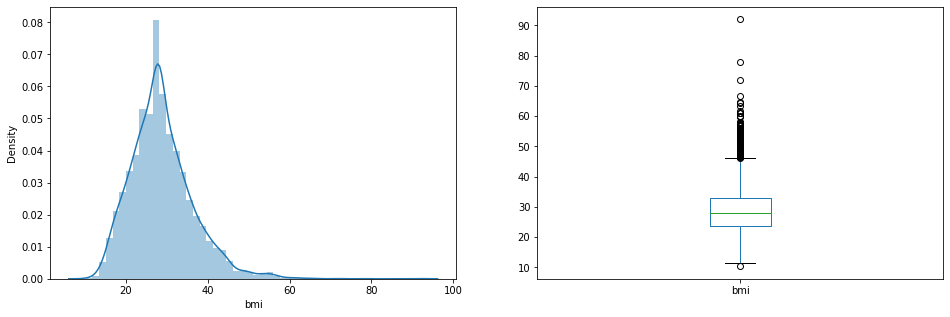

In [ ]:
# Checking the distribution of the predictor variables. 
# Here, we will use both distplot and boxplot as shown below. 
# Let us plot each variable to show its distribution in the dataset.
#fig, ax = plt.subplots(figsize = (6,6), dpi = 70)
plt.figure(1)
plt.title('BMI Distribution before droping the abnormal entry')
plt.subplot(121), sns.distplot(num_data['bmi'])
plt.subplot(122), num_data['bmi'].plot.box(figsize=(16,5))
plt.show()

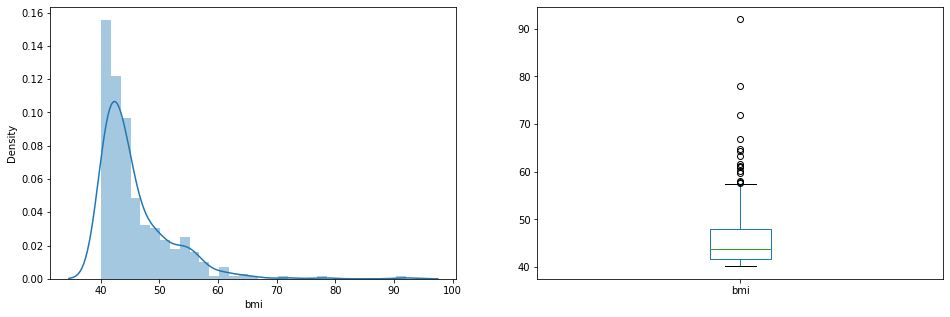

In [ ]:
plt.figure(1)
plt.title('Stroke Distribution with BMI over 40')
plt.subplot(121), sns.distplot(bmi_over_40['bmi'])
plt.subplot(122), bmi_over_40['bmi'].plot.box(figsize=(16,5))
plt.show()

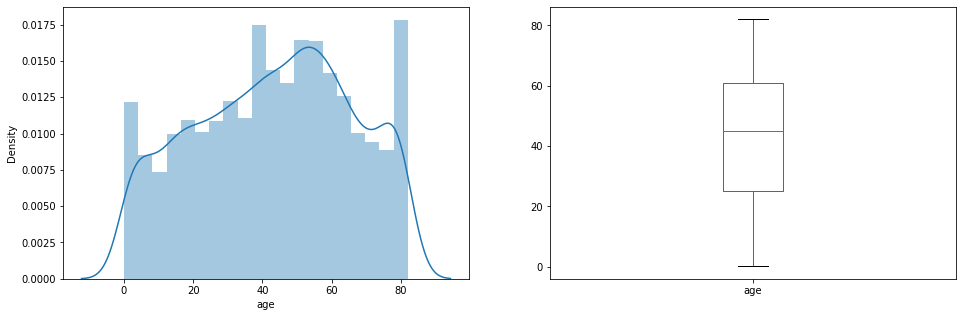

In [ ]:
plt.figure(1)
plt.subplot(121), sns.distplot(data['age'])
plt.subplot(122), data['age'].plot.box(figsize=(16,5))
plt.show()

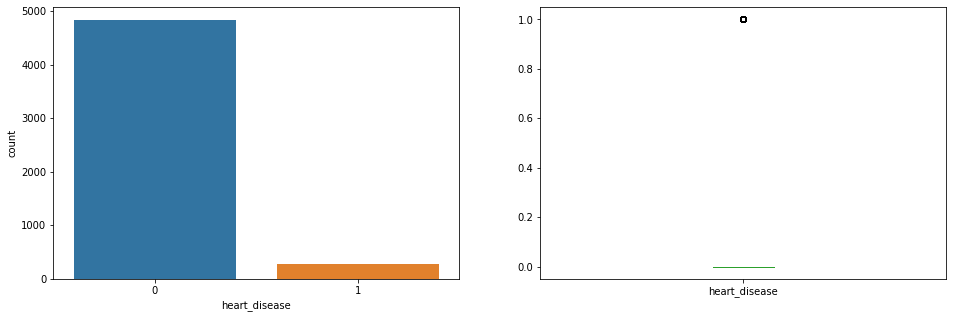

In [ ]:
plt.figure(1)
plt.subplot(121), sns.countplot(data['heart_disease'])
plt.subplot(122), data['heart_disease'].plot.box(figsize=(16,5))
plt.show()

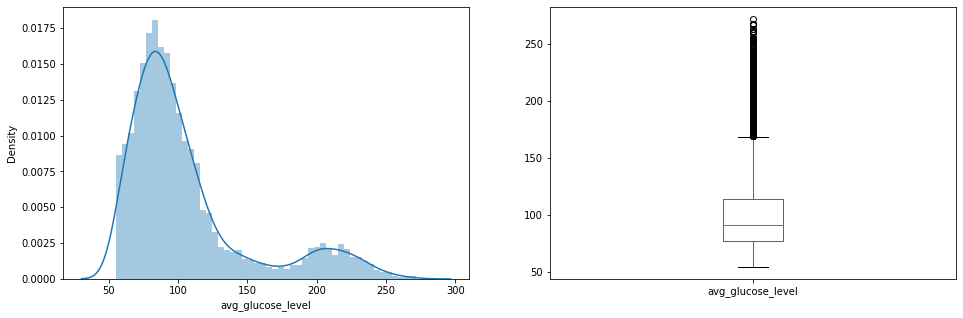

In [ ]:
plt.figure(1)
plt.subplot(121), sns.distplot(data['avg_glucose_level'])
plt.subplot(122), data['avg_glucose_level'].plot.box(figsize=(16,5))
plt.show()

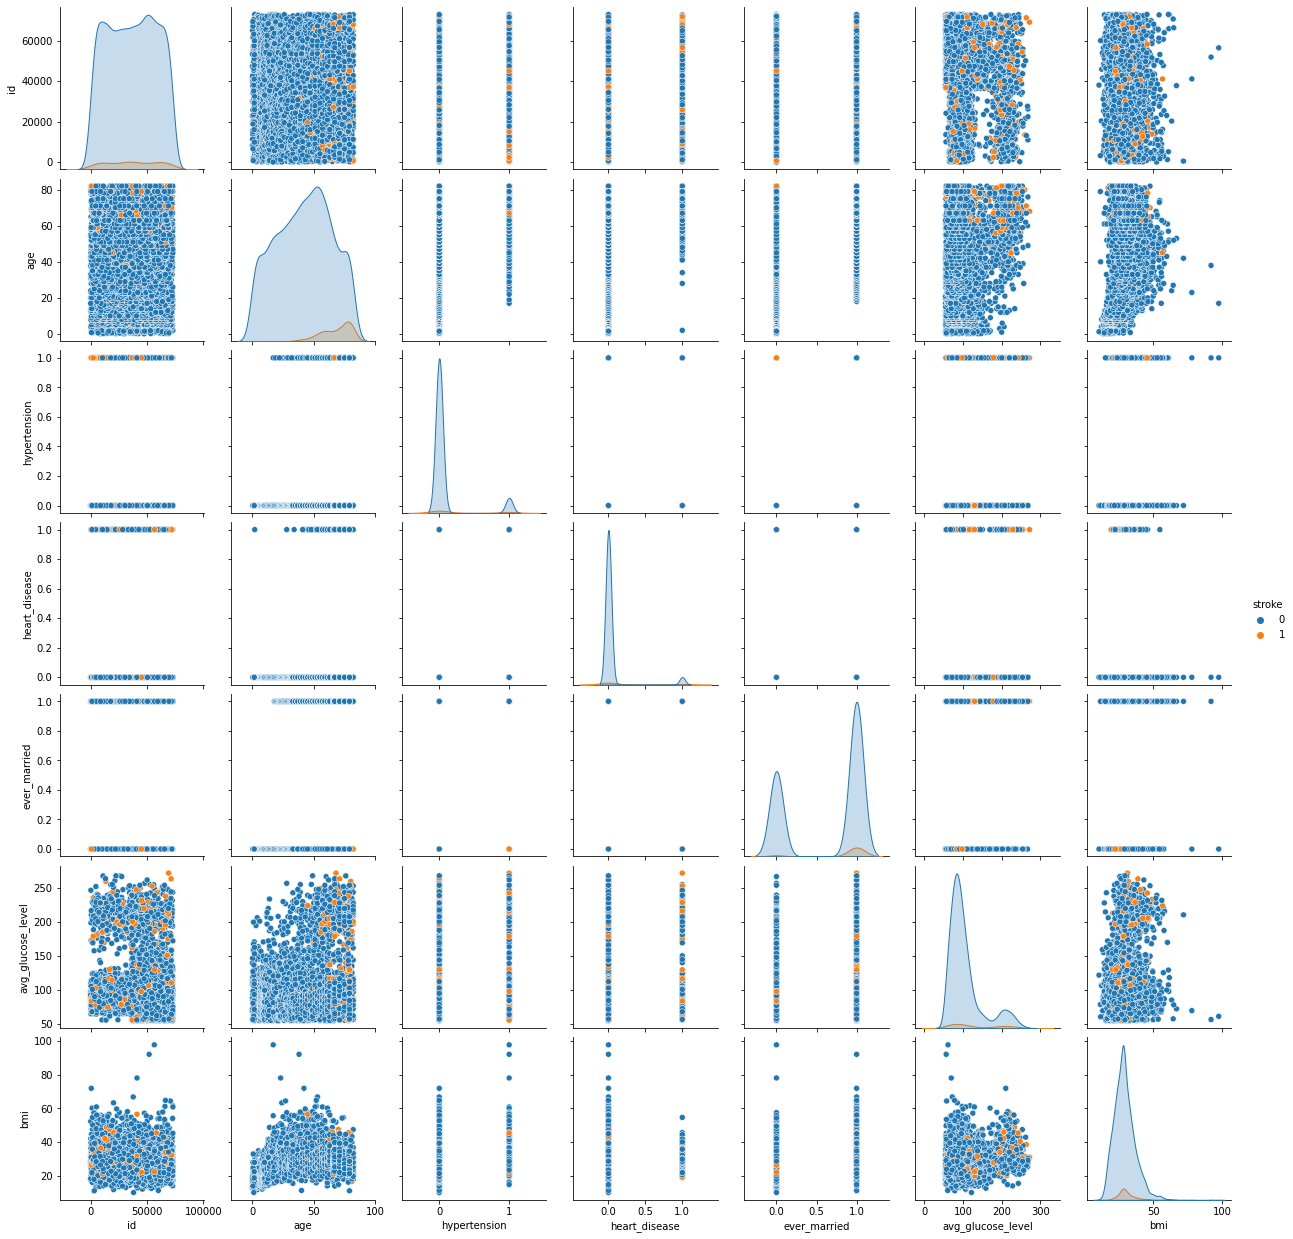

In [ ]:
import warnings
warnings.filterwarnings('ignore')
sns.pairplot(data, hue= 'stroke')
plt.show()

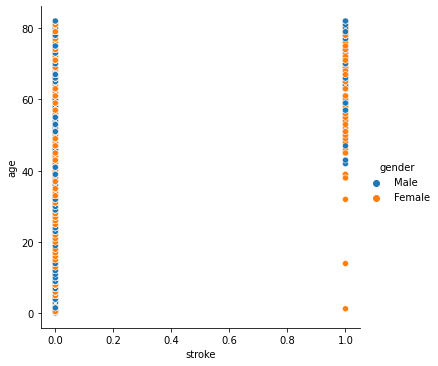

In [ ]:
sns.relplot(x='stroke', y='age', hue='gender', data=data ) 
plt.show()

With this it seems that a confusion matrix and a logistic regression may have a better relationship because this is showing that there is not a linear relationship.

From this bar chart we can clearly see that for people over 40 years old the majority suffered a stroke. We have an uptick at age 40 then it drops until about age 55 through 65 and drops again and goes all the way up at age 80.

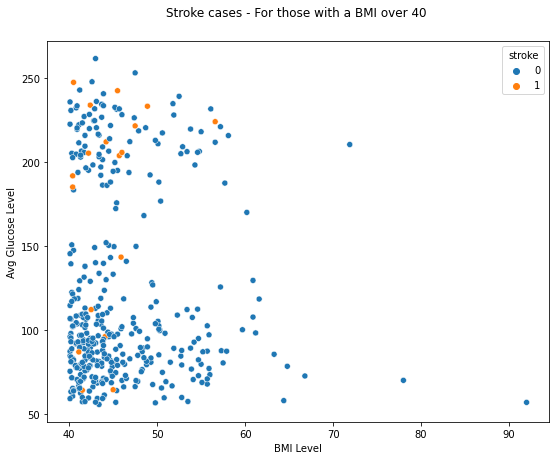

In [ ]:
# Scatter Plot
plt.figure(figsize = (9,7))
sns.scatterplot(x = 'bmi', y = 'avg_glucose_level', hue = 'stroke', data =bmi_over_40)
plt.title('Stroke cases - For those with a BMI over 40 ',y=1.05)

plt.xlabel('BMI Level')
plt.ylabel('Avg Glucose Level')
plt.show()

# Hypothesis Testing

In [ ]:
def chi2_dependency(data_df, x,y):
    ctab = pd.crosstab(data_df[x], data_df[y])
    stat, p, dof, expected = chi2_contingency(ctab)
    alpha1 = 0.05
    alpha2 = 0.01
    print('--------------Chi Squared Hypothesis Test Results-------------------')
    print('Variable X: ',x)
    print('Variable Y: ',y)
    if p<alpha1 and p > alpha2:
        print('P-value: ',p)
        print('We reject the NUll Hypothesis H0')
        print('There is some evidence to suggest that {} and {} are dependent'.format(x,y))
    if p < alpha1 and p < alpha2:
        print('P-value: ',p)
        print('We reject the NUll Hypothesis H0')
        print('There is substantial evidence to suggest that {} and {} are dependent'.format(x,y))
    else:
        print('P-value: ',p)
        print('We fail to reject the NUll Hypothesis H0')
        print('There is no evidence to suggest that {} and {} are independent'.format(x,y))
        
    print()

In [ ]:
chi2_dependency(data,'gender','stroke')
chi2_dependency(data,'ever_married','stroke')
chi2_dependency(data,'hypertension','stroke')
chi2_dependency(data,'heart_disease','stroke')
chi2_dependency(data,'work_type','stroke')
chi2_dependency(data,'Residence_type','stroke')
chi2_dependency(data,'smoking_status','stroke')

--------------Chi Squared Hypothesis Test Results-------------------
Variable X:  gender
Variable Y:  stroke
P-value:  0.5598277580669416
We fail to reject the NUll Hypothesis H0
There is no evidence to suggest that gender and stroke are independent

--------------Chi Squared Hypothesis Test Results-------------------
Variable X:  ever_married
Variable Y:  stroke
P-value:  1.6862856191673454e-14
We reject the NUll Hypothesis H0
There is substantial evidence to suggest that ever_married and stroke are dependent

--------------Chi Squared Hypothesis Test Results-------------------
Variable X:  hypertension
Variable Y:  stroke
P-value:  1.688936253410575e-19
We reject the NUll Hypothesis H0
There is substantial evidence to suggest that hypertension and stroke are dependent

--------------Chi Squared Hypothesis Test Results-------------------
Variable X:  heart_disease
Variable Y:  stroke
P-value:  2.120831133146208e-21
We reject the NUll Hypothesis H0
There is substantial evidence to sugg

Gender and Residential Type do not seem to have an impact on stroke
Smoking Status, Work Type, Heart Disease, Hypertension and Married status have an impact on stroke

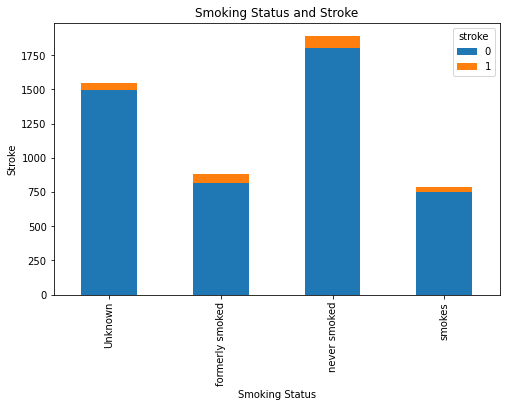

In [ ]:
ctab = pd.crosstab(data['smoking_status'], data['stroke'])


ctab.plot.bar(stacked = True, figsize = (8,5))
plt.xlabel('Smoking Status')
plt.ylabel('Stroke')
plt.title('Smoking Status and Stroke')
plt.show()

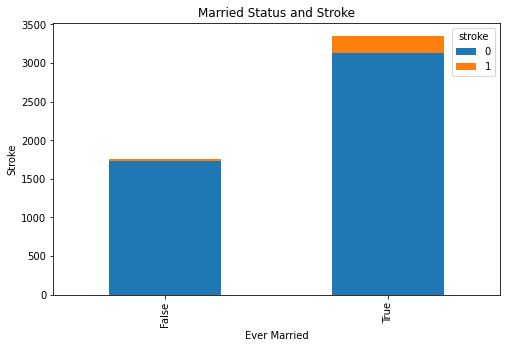

Ratio of stroke affected from ever_married class 0.07426185505517446
Ratio of stroke affected from never married class 0.1417995444191344


In [ ]:
ctab = pd.crosstab(data['ever_married'], data['stroke'])

ctab.plot.bar(stacked = True, figsize = (8,5))
plt.xlabel('Ever Married')
plt.ylabel('Stroke')
plt.title('Married Status and Stroke')
plt.show()

print('Ratio of stroke affected from ever_married class',
      len(data[data['stroke']==1])/len(data[data['ever_married']==True]))
      
print('Ratio of stroke affected from never married class',
      len(data[data['stroke']==1])/len(data[data['ever_married']==False]))

In [ ]:
target_col = ['stroke']
num_cols = ['id', 'age', 'avg_glucose_level', 'bmi']
cat_cols = [col for col in data.columns if col not in num_cols+target_col]

In [ ]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
data['gender'] = label_encoder.fit_transform(data['gender'])
data['ever_married'] = label_encoder.fit_transform(data['ever_married'])
data['Residence_type'] = label_encoder.fit_transform(data['Residence_type'])

In [ ]:
data = pd.get_dummies(data, prefix = ['work_type'], columns = ['work_type'])
data = pd.get_dummies(data, prefix = ['smoking_status'], columns = ['smoking_status'])

In [ ]:
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,64128,1,10.0,0,0,0,1,63.08,20.5,0,0,0,0,0,1,0,0,0,1
1,4833,0,12.0,0,0,0,0,207.45,25.4,0,0,0,0,0,1,0,0,0,1
2,42821,0,13.0,0,0,0,0,60.69,24.0,0,0,0,1,0,0,0,0,0,1
3,37395,0,16.0,0,0,0,1,63.63,20.0,0,0,0,1,0,0,0,0,0,1
4,63312,1,16.0,0,0,0,1,80.55,23.5,0,0,0,1,0,0,0,0,0,1


In [ ]:
# Create the input for the run 
input = [vectice.create_dataset_version().with_parent_name("Stroke Data Clean")]
# Create the run
run = vectice.create_run("Stroke Data Training", JobType.TRAINING)
# Start the run with the run and inputs
vectice.start_run(run, inputs=input)

In [ ]:
# Alter data to be conducive for a BigQuery ingest job. 
names_types = [("_".join(col.split("-")) if "-" in col else "_".join(col.split(" ")), data[col].dtype if data[col].dtype != 'uint8' else "INT") for col in data.columns]
# The column names must match in the DataFrame and BigQuery ingestion. For example Big Query doesn't accept "-" in column names.
data = data.rename(columns={x:y[0] for x,y in zip(data.columns, names_types)})

In [ ]:
# TODO(developer): Set table_id to the ID of the table to create.
table_id = "nodal-unity-277700.healthcareData.StrokeDataTraining"

job_config = bigquery.LoadJobConfig(
    schema=[bigquery.SchemaField(col, str(data[col].dtype if data[col].dtype != 'uint8' else "INT64")) for col in data.columns],
)

load_job = client.load_table_from_dataframe(
    data, table_id, job_config=job_config
)  # Make an API request.

load_job.result()  # Waits for the job to complete.

destination_table = client.get_table(table_id)  # Make an API request.
print("Loaded {} rows.".format(destination_table.num_rows))

Loaded 5110 rows.


In [ ]:
|# Creating the new training data as an output
output = [vectice.create_dataset_version().with_parent_name("Stroke Training Data")]
vectice.end_run(outputs=output)

2069

In [ ]:
#Splitting the dataset
x = num_data.drop('stroke', axis=1)
y = num_data.stroke

In [ ]:
from sklearn.model_selection import train_test_split

xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size = 0.3, random_state=1)

In [ ]:
#include categorical values in the dataset
#Since we are using a Tree based model, One-Hot encoding is not an absolute necessity
#However, this dataset, train and test sets will be updated whenever one-hot encoding will be used
from sklearn.model_selection import train_test_split

#Splitting the dataset
x = data.drop('stroke', axis=1)
y = data.stroke

xtrain, xtest, ytrain, ytest = train_test_split(x, y, train_size = 0.3, random_state=1)

In [ ]:
#Before proceeding for tree based models, lets check rank of feature importance on a decision tree
from sklearn.tree import DecisionTreeClassifier
dt = DecisionTreeClassifier()
dt.fit(xtrain,ytrain)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
print(len(xtrain.columns.tolist()))
len(dt.feature_importances_)

18


18

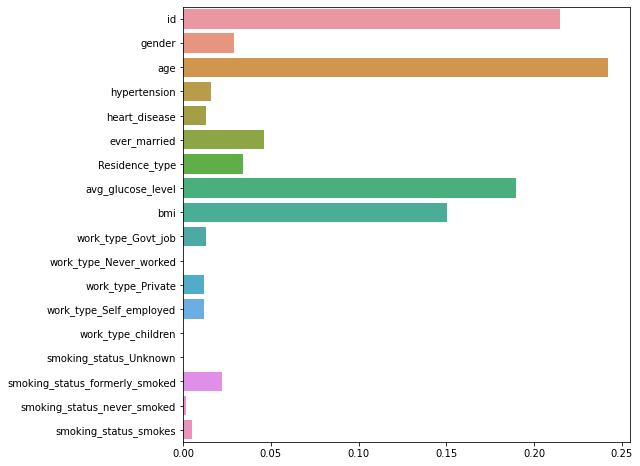

In [ ]:
plt.figure(figsize = (8,8))
sns.barplot(x = dt.feature_importances_, y = xtrain.columns.tolist())

In [ ]:
#Building the model using RandomForest
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=500)
rfc.fit(xtrain, ytrain)
preds = rfc.predict(xtest)

print('Predictions',list(preds[0:500]))

Predictions [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(ytest, preds)

array([[3400,    0],
       [ 177,    0]])

True positives are on the upper left. Then the botton right is the true negative. Which means, that I was supposed a negative and the model got a negative.

The false positive is the number on the upper right. False negative are the numbers on the bottom left.

Here we have the True negatives or 0s because we don't have many cases of strokes. Meaning that 3,388 people did not have a stroke.

On the inverse we have the True positive or 1s for those who suffered a stroke.

is the False negative, those who were predicted as 1 but they were 0s. Number 13

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score_dt = accuracy_score(ytest,preds)
accuracy_score_dt

0.9505171931786414

In [ ]:
from sklearn.metrics import f1_score
f1_score_dt = f1_score(ytest, preds, average='micro')
f1_score_dt

0.9505171931786414

In [ ]:
# You can create ModelVersionArtifacts in a list
non_smote_models = [vectice.create_model_version().with_parent_name("DecisionTreeClassifier").with_algorithm("Decision Tree Classifier").with_user_version('1').with_metrics([("Accuracy Score", accuracy_score_dt), ("F1 Score", f1_score_dt)])]

True positives are on the upper left. The botton right is for true negatives. Which means, that I was supposed a negative and the model got a negative.

The false positive is the number on the upper right. False negative are the numbers on the bottom left.

Gradient Boost Classifier
Include categorical values in the dataset. Since we are using a Tree based model, One-Hot encoding is not an absolute necessity

However, this dataset, tran and test sets will be update whenever one-hot enconding will be use

In [ ]:
#Splitting the data set
x = data.drop('stroke', axis = 1)
y = data.stroke

xtrain, xtest, ytrain, ytest = train_test_split(x,y, train_size = 0.3, random_state =1)

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier(random_state = 123, n_estimators = 500)
gbc.fit(xtrain,ytrain)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=500,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=123, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [ ]:
preds = gbc.predict(xtest)
print(confusion_matrix(ytest, preds))
print(classification_report(ytest, preds, output_dict = True))
accuracy_score_gbc = accuracy_score(ytest, preds)
f1_score_gbc = f1_score(ytest,preds)
print('Accuracy Score: ',accuracy_score(ytest, preds))
print('F1 Score: ',f1_score(ytest,preds))

[[3367   33]
 [ 170    7]]
{'0': {'precision': 0.9519366694939214, 'recall': 0.9902941176470588, 'f1-score': 0.970736629667003, 'support': 3400}, '1': {'precision': 0.175, 'recall': 0.03954802259887006, 'f1-score': 0.06451612903225806, 'support': 177}, 'accuracy': 0.9432485322896281, 'macro avg': {'precision': 0.5634683347469607, 'recall': 0.5149210701229644, 'f1-score': 0.5176263793496305, 'support': 3577}, 'weighted avg': {'precision': 0.9134916623649239, 'recall': 0.9432485322896281, 'f1-score': 0.925894295696539, 'support': 3577}}
Accuracy Score:  0.9432485322896281
F1 Score:  0.06451612903225806


In [ ]:
# You can then append more models to said list. 
non_smote_models.append(vectice.create_model_version().with_parent_name("GradientBoostingClassifier").with_algorithm("Gradient Boosting Classifier").with_user_version('1').with_metrics([("Accuracy Score", accuracy_score_gbc), ("F1 Score", f1_score_gbc)]))
non_smote_models

[ModelVersionArtifact(None,ModelVersion(metrics=[Metric(key='Accuracy Score', value=0.9505171931786414, timestamp=datetime.datetime(2021, 8, 3, 9, 59, 30, 815337), name=None), Metric(key='F1 Score', value=0.9505171931786414, timestamp=datetime.datetime(2021, 8, 3, 9, 59, 30, 815348), name=None)], properties=None, version=None, userDeclaredVersion=UserDeclaredVersion(userVersion='1', name=None, uri=None, description=None), parentName='DecisionTreeClassifier', parentId=None, tags=None, algorithmName='Decision Tree Classifier')),
 ModelVersionArtifact(None,ModelVersion(metrics=[Metric(key='Accuracy Score', value=0.9432485322896281, timestamp=datetime.datetime(2021, 8, 3, 9, 59, 34, 967705), name=None), Metric(key='F1 Score', value=0.06451612903225806, timestamp=datetime.datetime(2021, 8, 3, 9, 59, 34, 967716), name=None)], properties=None, version=None, userDeclaredVersion=UserDeclaredVersion(userVersion='1', name=None, uri=None, description=None), parentName='GradientBoostingClassifier',

Using SMOTE¶

SMOTE is a technique to artificially oversample the minority class by creating synthetic samples. These synthetic samples are created by finding the intermediate values between neighbouring samples of minority class

SMOTE is applied ONLY on the training set and not on the test set to avoid biased results

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
xtrain_mod, ytrain_mod = sm.fit_resample(xtrain, ytrain)

In [ ]:
input = [vectice.create_dataset_version().with_parent_name("Stroke Training Data")]
run = vectice.create_run("SMOTE Dataset", JobType.PREPARATION)
vectice.start_run(run, inputs=input)

In [ ]:
smote_x = pd.DataFrame(xtrain_mod)
smote_y = pd.DataFrame(ytrain_mod)

In [ ]:
# Merge smote x & y into a DataFrame
smote_data = pd.merge(smote_x, smote_y, on=smote_x.index)
# Rename columns so Big Query allows the table creation
smote_data = smote_data.rename(columns={col:f"col_{str(col)}" for col in smote_data.columns})

In [ ]:
# TODO(developer): Set table_id to the ID of the table to create.
table_id = "nodal-unity-277700.healthcareData.StrokeDataTrainingSMOTE"

job_config = bigquery.LoadJobConfig(
    schema=[bigquery.SchemaField(str(col), str(smote_data[col].dtype)) for col in smote_data.columns]
    # The source format defaults to CSV, so the line below is optional.
)

load_job = client.load_table_from_dataframe(
    smote_data, table_id, job_config=job_config
)  # Make an API request.

load_job.result()  # Waits for the job to complete.

destination_table = client.get_table(table_id)  # Make an API request.
print("Loaded {} rows.".format(destination_table.num_rows))

Loaded 2922 rows.


In [ ]:
output = [vectice.create_dataset_version().with_parent_name("Stroke SMOTE Data")]
vectice.end_run(outputs=output)

2073

In [ ]:
gbc2 = GradientBoostingClassifier(random_state = 123, n_estimators = 30, max_depth = 2)
gbc2.fit(xtrain_mod,ytrain_mod)
preds = gbc2.predict(xtest)
print(confusion_matrix(ytest, preds))

accuracy_score_gbc_smote = accuracy_score(ytest, preds)
f1_score_gbc_smote = f1_score(ytest,preds)
print('Accuracy Score: ',accuracy_score(ytest, preds))
print('F1 Score: ',f1_score(ytest,preds))

[[3136  264]
 [ 144   33]]
Accuracy Score:  0.885937936818563
F1 Score:  0.13924050632911392


In [ ]:
# Create a list for all the smote models
smote_models = [vectice.create_model_version().with_parent_name("GradientBoostingClassifier").with_algorithm("Gradient Boosting Classifier SMOTE").with_user_version('2').with_metrics([("Accuracy Score", accuracy_score_gbc_smote), ("F1 Score", f1_score_gbc_smote)]).with_status(ModelVersionStatus.EXPERIMENTATION).with_type(ModelType.CLASSIFICATION)]

In [ ]:
#Fitting model on non-SMOTE dataset
xgb1 = XGBClassifier(n_estimators = 250)
xgb1.fit(xtrain, ytrain)
preds = xgb1.predict(xtest)
print(confusion_matrix(ytest, preds))

train_preds = xgb1.predict(xtrain)
print('Train Accuracy Score: ',accuracy_score(ytrain, train_preds))
print('Train F1 Score: ',f1_score(ytrain, train_preds))

print('Test Accuracy Score: ',accuracy_score(ytest, preds))
print('F1 Score: ',f1_score(ytest,preds))

[[3380   20]
 [ 172    5]]
Train Accuracy Score:  0.9778212654924984
Train F1 Score:  0.6909090909090909
Test Accuracy Score:  0.9463237349734415
F1 Score:  0.04950495049504951


In [ ]:
#Applying on non-SMOTE dataset
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(xtrain, ytrain)

preds = gnb.predict(xtest)
print(confusion_matrix(ytest, preds))

train_preds = gnb.predict(xtrain)
print('Train Accuracy Score: ',accuracy_score(ytrain, train_preds))
print('Train F1 Score: ',f1_score(ytrain, train_preds))
accuracy_score_gnb = accuracy_score(ytest, preds)
f1_score_gnb = f1_score(ytest,preds)
print('Accuracy Score: ',accuracy_score(ytest, preds))
print('F1 Score: ',f1_score(ytest,preds))

[[3228  172]
 [ 140   37]]
Train Accuracy Score:  0.9204174820613177
Train F1 Score:  0.22784810126582278
Accuracy Score:  0.9127760693318423
F1 Score:  0.1917098445595855


In [ ]:
non_smote_models.append(vectice.create_model_version().with_parent_name("GaussianNB").with_algorithm("Gaussian NB").with_user_version('1').with_metrics([("Accuracy Score", accuracy_score_gnb), ("F1 Score", f1_score_gnb)]).with_status(ModelVersionStatus.EXPERIMENTATION).with_type(ModelType.CLASSIFICATION))
non_smote_models

[ModelVersionArtifact(None,ModelVersion(metrics=[Metric(key='Accuracy Score', value=0.9505171931786414, timestamp=datetime.datetime(2021, 8, 3, 9, 59, 30, 815337), name=None), Metric(key='F1 Score', value=0.9505171931786414, timestamp=datetime.datetime(2021, 8, 3, 9, 59, 30, 815348), name=None)], properties=None, version=None, userDeclaredVersion=UserDeclaredVersion(userVersion='1', name=None, uri=None, description=None), parentName='DecisionTreeClassifier', parentId=None, tags=None, algorithmName='Decision Tree Classifier')),
 ModelVersionArtifact(None,ModelVersion(metrics=[Metric(key='Accuracy Score', value=0.9432485322896281, timestamp=datetime.datetime(2021, 8, 3, 9, 59, 34, 967705), name=None), Metric(key='F1 Score', value=0.06451612903225806, timestamp=datetime.datetime(2021, 8, 3, 9, 59, 34, 967716), name=None)], properties=None, version=None, userDeclaredVersion=UserDeclaredVersion(userVersion='1', name=None, uri=None, description=None), parentName='GradientBoostingClassifier',

In [ ]:
#Applying on SMOTE dataset
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(xtrain_mod, ytrain_mod)

preds = gnb.predict(xtest)
print(confusion_matrix(ytest, preds))

train_preds = gnb.predict(xtrain_mod)
print('Train Accuracy Score: ',accuracy_score(ytrain_mod, train_preds))
print('Train F1 Score: ',f1_score(ytrain_mod, train_preds))
accuracy_score_gnb_smote = accuracy_score(ytest, preds)
f1_score_gnb_smote = f1_score(ytest,preds)
print('Accuracy Score: ',accuracy_score(ytest, preds))
print('F1 Score: ',f1_score(ytest,preds))

[[2228 1172]
 [  24  153]]
Train Accuracy Score:  0.7932922655715263
Train F1 Score:  0.8187274909963985
Accuracy Score:  0.6656415991053956
F1 Score:  0.20372836218375498


In [ ]:
smote_models.append(vectice.create_model_version().with_parent_name("GaussianNB").with_algorithm("Gaussian NB SMOTE").with_user_version('2').with_metrics([("Accuracy Score", accuracy_score_gnb_smote), ("F1 Score", f1_score_gnb_smote)]).with_status(ModelVersionStatus.EXPERIMENTATION).with_type(ModelType.CLASSIFICATION))
smote_models

[ModelVersionArtifact(None,ModelVersion(metrics=[Metric(key='Accuracy Score', value=0.885937936818563, timestamp=datetime.datetime(2021, 8, 3, 10, 12, 24, 143337), name=None), Metric(key='F1 Score', value=0.13924050632911392, timestamp=datetime.datetime(2021, 8, 3, 10, 12, 24, 143347), name=None)], properties=None, version=None, userDeclaredVersion=UserDeclaredVersion(userVersion='2', name=None, uri=None, description=None), parentName='GradientBoostingClassifier', parentId=None, tags=None, algorithmName='Gradient Boosting Classifier SMOTE')),
 ModelVersionArtifact(None,ModelVersion(metrics=[Metric(key='Accuracy Score', value=0.6656415991053956, timestamp=datetime.datetime(2021, 8, 3, 10, 12, 28, 291062), name=None), Metric(key='F1 Score', value=0.20372836218375498, timestamp=datetime.datetime(2021, 8, 3, 10, 12, 28, 291075), name=None)], properties=None, version=None, userDeclaredVersion=UserDeclaredVersion(userVersion='2', name=None, uri=None, description=None), parentName='GaussianNB

We observe that there is a significant increase in True negatives, but there are also a significant increase in false negatives

Earlier, we had noticed that Gender and Residence_type do not have an impact on stroke.

To strengthen our classifier, they can be dropped from train and test X dataset

In [ ]:
#Applying on SMOTE dataset
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(xtrain, ytrain)

preds = knn.predict(xtest)
print(confusion_matrix(ytest, preds))

train_preds = knn.predict(xtrain)
print('Train Accuracy Score: ',accuracy_score(ytrain, train_preds))
print('Train F1 Score: ',f1_score(ytrain, train_preds))
accuracy_score_knn = accuracy_score(ytest, preds)
f1_score_knn = f1_score(ytest,preds)
print('Accuracy Score: ',accuracy_score(ytest, preds))
print('F1 Score: ',f1_score(ytest,preds))

[[3387   13]
 [ 176    1]]
Train Accuracy Score:  0.9549902152641878
Train F1 Score:  0.10389610389610389
Accuracy Score:  0.9471624266144814
F1 Score:  0.010471204188481674


In [ ]:
non_smote_models.append(vectice.create_model_version().with_parent_name("KNeighborsClassifier").with_algorithm("KNeighbors Classifier").with_user_version('1').with_metrics([("Accuracy Score", accuracy_score_knn), ("F1 Score", f1_score_knn)]).with_status(ModelVersionStatus.EXPERIMENTATION).with_type(ModelType.CLASSIFICATION))
non_smote_models

[ModelVersionArtifact(None,ModelVersion(metrics=[Metric(key='Accuracy Score', value=0.9505171931786414, timestamp=datetime.datetime(2021, 8, 3, 9, 59, 30, 815337), name=None), Metric(key='F1 Score', value=0.9505171931786414, timestamp=datetime.datetime(2021, 8, 3, 9, 59, 30, 815348), name=None)], properties=None, version=None, userDeclaredVersion=UserDeclaredVersion(userVersion='1', name=None, uri=None, description=None), parentName='DecisionTreeClassifier', parentId=None, tags=None, algorithmName='Decision Tree Classifier')),
 ModelVersionArtifact(None,ModelVersion(metrics=[Metric(key='Accuracy Score', value=0.9432485322896281, timestamp=datetime.datetime(2021, 8, 3, 9, 59, 34, 967705), name=None), Metric(key='F1 Score', value=0.06451612903225806, timestamp=datetime.datetime(2021, 8, 3, 9, 59, 34, 967716), name=None)], properties=None, version=None, userDeclaredVersion=UserDeclaredVersion(userVersion='1', name=None, uri=None, description=None), parentName='GradientBoostingClassifier',

In [ ]:
#Applying on SMOTE dataset

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=2, p=1)

knn.fit(xtrain_mod, ytrain_mod)

preds = knn.predict(xtest)
print(confusion_matrix(ytest, preds))

train_preds = knn.predict(xtrain_mod)
print('Train Accuracy Score: ',accuracy_score(ytrain_mod, train_preds))
print('Train F1 Score: ',f1_score(ytrain_mod, train_preds))
accuracy_score_knn_smote = accuracy_score(ytest, preds)
f1_score_knn_smote = f1_score(ytest,preds)
print('Accuracy Score: ',accuracy_score(ytest, preds))
print('F1 Score: ',f1_score(ytest,preds))

[[2865  535]
 [ 129   48]]
Train Accuracy Score:  0.9236824093086927
Train F1 Score:  0.9173768062245277
Accuracy Score:  0.8143695834498182
F1 Score:  0.12631578947368421


In [ ]:
smote_models.append(vectice.create_model_version().with_parent_name("KNeighborsClassifiers").with_algorithm("KNeighbors Classifier SMOTE").with_user_version('2').with_metrics([("Accuracy Score", accuracy_score_knn_smote), ("F1 Score", f1_score_knn_smote)]).with_status(ModelVersionStatus.EXPERIMENTATION).with_type(ModelType.CLASSIFICATION))
smote_models

[ModelVersionArtifact(None,ModelVersion(metrics=[Metric(key='Accuracy Score', value=0.885937936818563, timestamp=datetime.datetime(2021, 8, 3, 10, 12, 24, 143337), name=None), Metric(key='F1 Score', value=0.13924050632911392, timestamp=datetime.datetime(2021, 8, 3, 10, 12, 24, 143347), name=None)], properties=None, version=None, userDeclaredVersion=UserDeclaredVersion(userVersion='2', name=None, uri=None, description=None), parentName='GradientBoostingClassifier', parentId=None, tags=None, algorithmName='Gradient Boosting Classifier SMOTE')),
 ModelVersionArtifact(None,ModelVersion(metrics=[Metric(key='Accuracy Score', value=0.6656415991053956, timestamp=datetime.datetime(2021, 8, 3, 10, 12, 28, 291062), name=None), Metric(key='F1 Score', value=0.20372836218375498, timestamp=datetime.datetime(2021, 8, 3, 10, 12, 28, 291075), name=None)], properties=None, version=None, userDeclaredVersion=UserDeclaredVersion(userVersion='2', name=None, uri=None, description=None), parentName='GaussianNB

In [ ]:
# As you've accumulated all your models, you can simply create a run to assign them to a job run. 
# Creating SMOTE training data as an input 
training_data = [vectice.create_dataset_version().with_parent_name("Stroke SMOTE Data")]
# Creating the Smote Models run
run = vectice.create_run("SMOTE Models", JobType.TRAINING)
vectice.start_run(run, inputs=training_data)
vectice.end_run(outputs=smote_models)

2072

In [ ]:
# Creating training data as an input 
training_data = [vectice.create_dataset_version().with_parent_name("Stroke Training Data")]
# Creating the Non-Smote Models run
run = vectice.create_run("Non-SMOTE Models", JobType.TRAINING)
vectice.start_run(run, inputs=training_data)
vectice.end_run(outputs=non_smote_models)